In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt 
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import math
from math import factorial
from sklearn.metrics import mean_squared_error, mean_absolute_error


/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('aaba.us.txt')

In [3]:
data.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1996-04-12,1.05,1.79,1.02,1.38,408720000,0
1,1996-04-15,1.49,1.50,1.25,1.34,79231200,0
2,1996-04-16,1.34,1.34,1.17,1.20,48026400,0
3,1996-04-17,1.18,1.18,1.03,1.12,42871200,0
4,1996-04-18,1.25,1.25,1.17,1.22,27352800,0


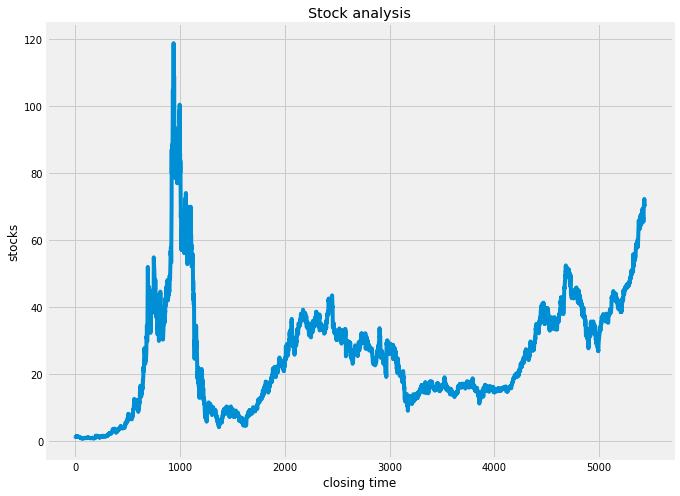

In [4]:
#visualisations 
plt.figure(figsize = (10, 8))
plt.title('Stock analysis')
#plt.plot(data.Close)
plt.plot(data['Close'])
plt.xlabel('closing time')
plt.ylabel('stocks')
plt.grid(True)
plt.show()

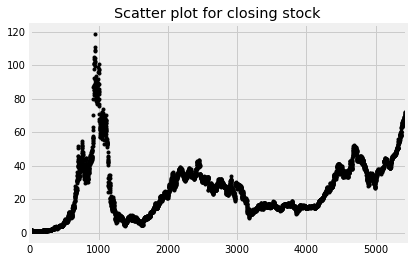

In [5]:
data.Close.plot(style  ='k.')
plt.title('Scatter plot for closing stock')
plt.show()

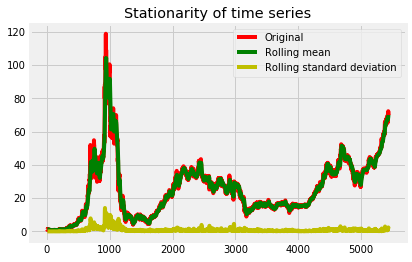

In [6]:
#now let's make the stationary series
#check if a series is stationary or not because time series only work with stationary data
#if both mean and standard deviation becomes flat lines,  the series becomes stationary


#test for stationarity
def stationarity(time_series):
    #determining rolling statistics 
    rol_mean = time_series.rolling(12).mean()
    rol_std = time_series.rolling(12).std()
    plt.plot(time_series, 'r', label = 'Original')
    plt.plot(rol_mean, 'g', label = 'Rolling mean')
    plt.plot(rol_std, 'y', label = 'Rolling standard deviation')
    plt.title('Stationarity of time series')
    plt.legend(loc = 'best')
stationarity(data.Close)
    
    

<Figure size 432x288 with 0 Axes>

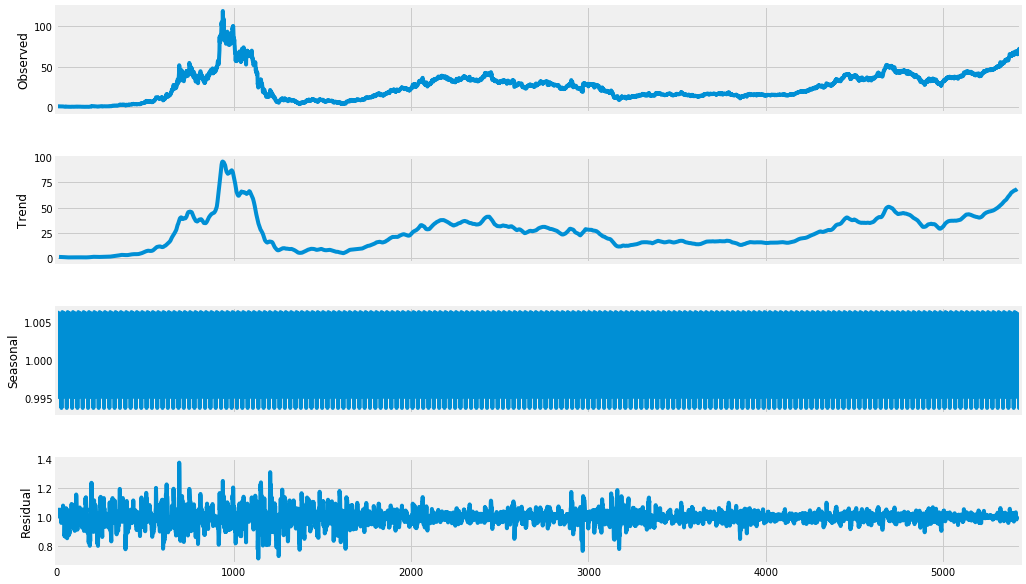

In [7]:
#ince both mean and std are increasing implies that the series is not stationary
#separate seasonality
result = seasonal_decompose(data.Close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


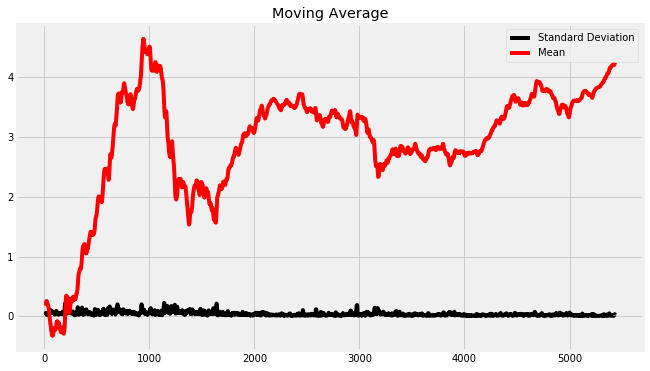

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(data.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()




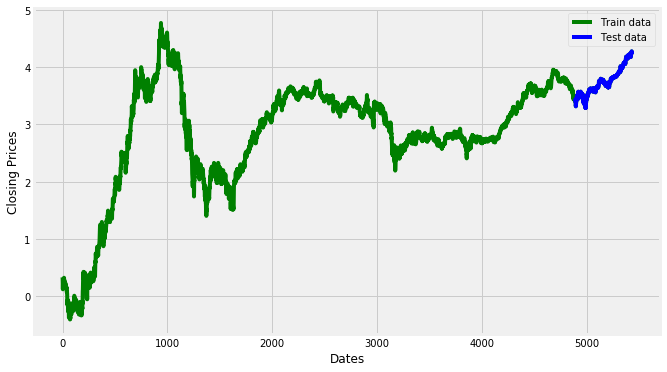

In [9]:
#arima model
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [11]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Fit ARIMA: order=(0, 1, 0); AIC=-18377.184, BIC=-18364.196, Fit time=0.041 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18375.274, BIC=-18355.792, Fit time=0.264 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18375.284, BIC=-18355.802, Fit time=0.371 seconds
Fit ARIMA: order=(1, 1, 1); AIC=-18379.329, BIC=-18353.353, Fit time=1.525 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-18386.349, BIC=-18353.878, Fit time=1.471 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-18386.124, BIC=-18360.148, Fit time=0.216 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-18384.600, BIC=-18345.635, Fit time=2.011 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-18394.402, BIC=-18348.943, Fit time=11.393 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-18384.514, BIC=-18345.549, Fit time=1.261 seconds
Fit ARIMA: order=(3, 1, 3); AIC=-18380.908, BIC=-18328.955, Fit time=4.318 seconds
Total fit time: 23.375 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:  

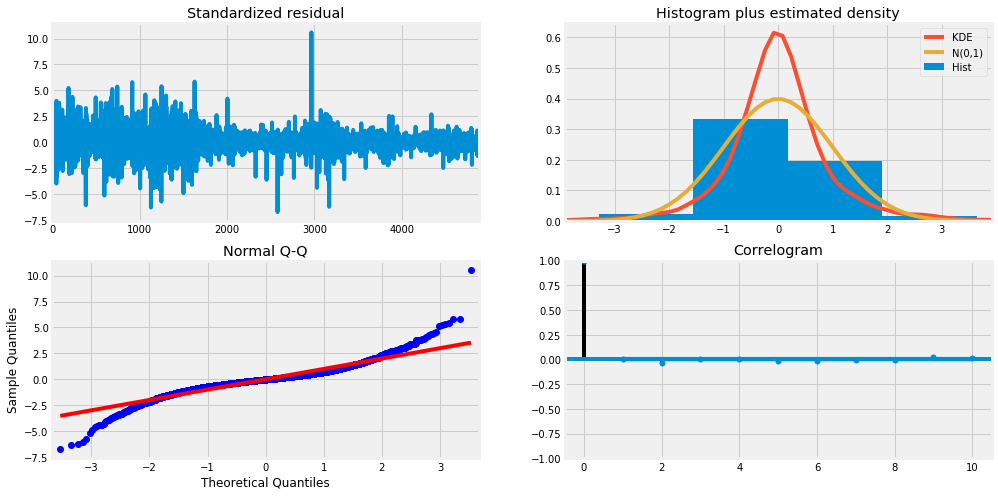

In [12]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [17]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4886
Model:                 ARIMA(3, 1, 2)   Log Likelihood                9204.201
Method:                       css-mle   S.D. of innovations              0.037
Date:                Thu, 13 Feb 2020   AIC                         -18394.402
Time:                        23:13:14   BIC                         -18348.943
Sample:                             1   HQIC                        -18378.450
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.292      0.197      -0.000       0.002
ar.L1.D.Close    -1.6322      0.017    -96.751      0.000      -1.665      -1.599
ar.L2.D.Close    -0.9840      0.025    -

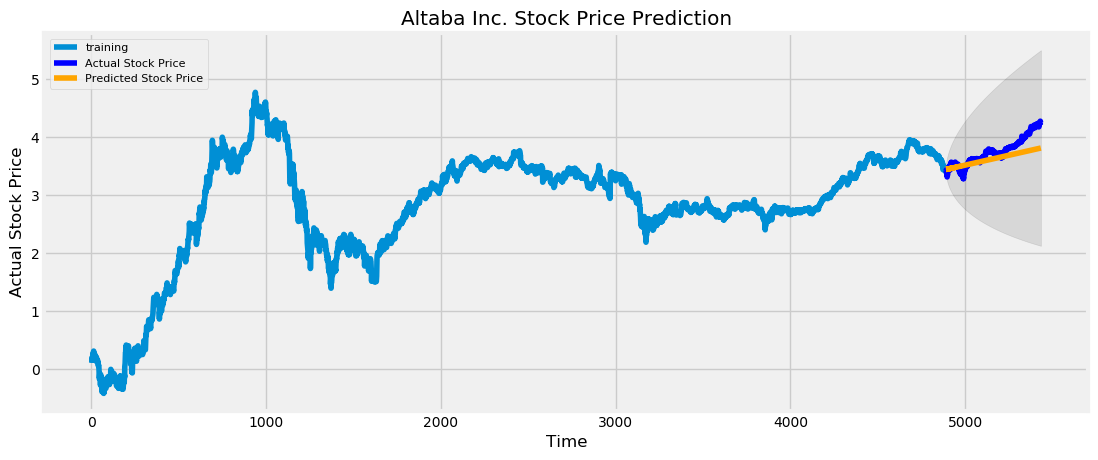

In [18]:
# Forecast
fc, se, conf = fitted.forecast(544, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.03331125547401547
MAE: 0.13801726692259716
RMSE: 0.1825137131122357
MAPE: 0.03533007946722583
